# Week 4 Data acqusition from Biosemi and OpenBCI

In [90]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

# 1.1 Read recorded data from Biosemi (bdf file)

In [91]:
# read biosami file (bdf)
raw_bio = mne.io.read_raw_bdf("data/Biosemi_data.bdf", preload=True) 
eegbci.standardize(raw_bio)

# Set channel location for data
montage = make_standard_montage("biosemi64")
raw_bio.set_montage(montage, on_missing='ignore')

Extracting EDF parameters from c:\git\BCI-Class-Material\Week4\data\Biosemi_data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143359  =      0.000 ...   279.998 secs...


Measurement date,"January 24, 2025 15:40:57 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"72 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


**check channel names**

In [92]:
raw_bio.ch_names

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'EXG5',
 'EXG6',
 'EXG7',
 'EXG8',
 'STATUS']

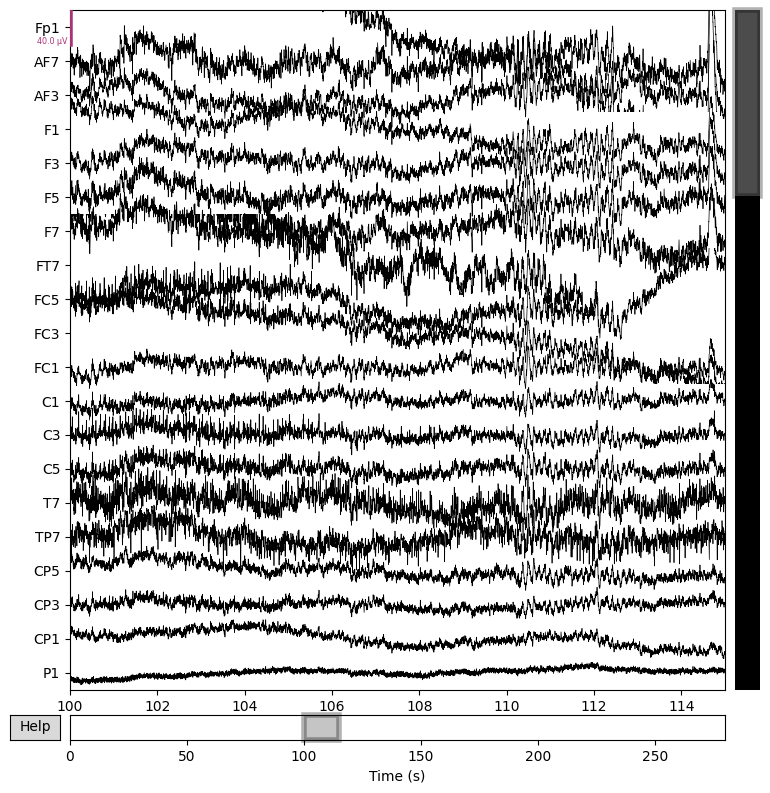

...


In [93]:
raw_bio.plot(start = 100, duration = 15)
print('...')

# 1.2 Read recorded data from Biosemi (bdf file)

In [94]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("data/OpenBCI_data.xdf") #Example Data from Lab Recoder
raw_data = streams[1]["time_series"].T #From Steam variable this query is EEG data
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
raw_OpenBCI = mne.io.RawArray(raw_data, info, verbose=False)    


In [95]:
raw_OpenBCI

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [96]:
raw_OpenBCI.ch_names

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

# 2. Apply filter

**raw data PSD plotting**

Effective window size : 4.000 (s)


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


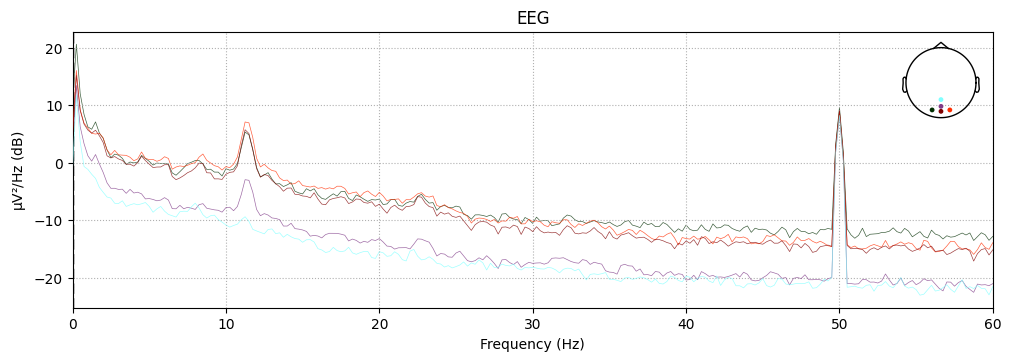

In [97]:
select_channels = ['O1', 'Oz', 'O2', 'Pz', 'POz']
raw_bio.compute_psd(fmax=60).plot(picks=select_channels)
plt.show()

Effective window size : 8.192 (s)


C:\Users\pipo_\AppData\Local\Temp\ipykernel_24956\4197467807.py:1: UserWarning: Zero value in spectrum for channels CH7, CH8
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
C:\Users\pipo_\AppData\Local\Temp\ipykernel_24956\4197467807.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


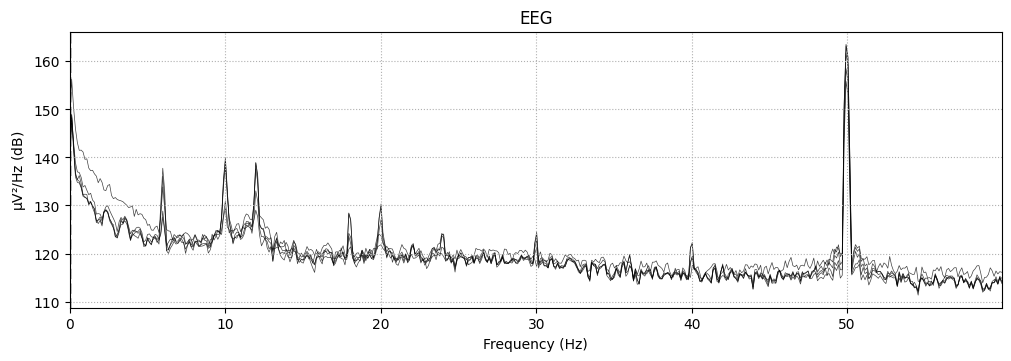

In [98]:
raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

**apply notch and band-pass filter**

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Effective window size : 4.000 (s)


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.2s finished
C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


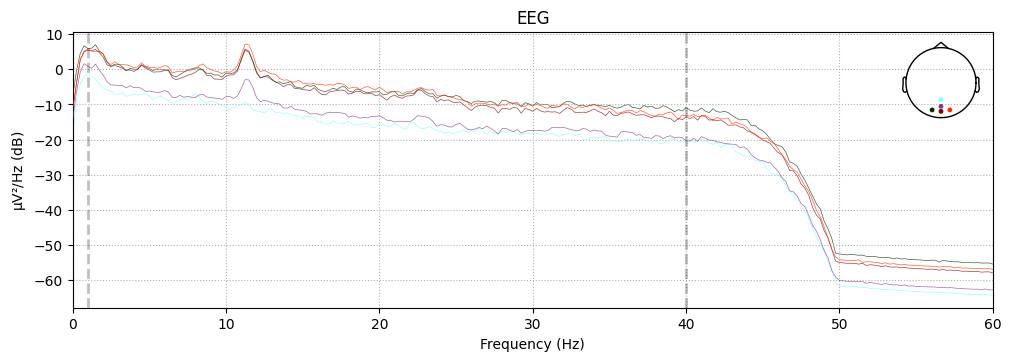

In [99]:
bio_filter = raw_bio.copy().notch_filter(freqs=50) #notch filter function
bio_filter = bio_filter.copy().filter(l_freq=1, h_freq=40) #band-pass function
bio_filter.compute_psd(fmax=60).plot(picks=select_channels)
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
C:\Users\pipo_\AppData\Local\Temp\ipykernel_24956\17556957

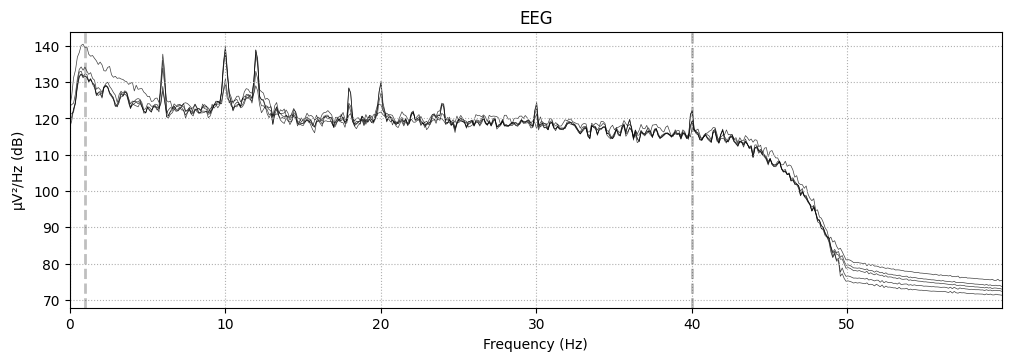

In [100]:
OpenBCI_filter = raw_OpenBCI.copy().notch_filter(freqs=50) #notch filter function
OpenBCI_filter = OpenBCI_filter.copy().filter(l_freq=1, h_freq=40) #band-pass function
OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()